In [1]:
from fastai.vision import *

from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import PascalVOCMetric

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = Path('.')
df = pd.read_csv(data_dir / 'stage_2_train_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [3]:
len(df)

30227

In [4]:
df = df[df['Target'] == 1]
df.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [5]:
len(df)

9555

In [6]:
img2bbox = collections.defaultdict(lambda : [[], []])
img2bbox['00436515-870c-4b36-a041-de91049b9ab4.jpg']

[[], []]

In [7]:
for n, row in df.iterrows():
    pid = row['patientId']
    img_file = str(f'{pid}.jpg')
    bbox = [row['y'], row['x'], row['height'] + row['y'], row['width'] + row['x']]
    img2bbox[img_file][0].append(bbox)
    img2bbox[img_file][1].append('pneumonia')
        
img2bbox['00436515-870c-4b36-a041-de91049b9ab4.jpg']

[[[152.0, 264.0, 531.0, 477.0], [152.0, 562.0, 605.0, 818.0]],
 ['pneumonia', 'pneumonia']]

In [8]:
get_y_func = lambda o:img2bbox[o.name]

In [9]:
size = 256
tfms = get_transforms()

data = (ObjectItemList.from_folder(data_dir / 'train' / 'PNEUMONIA')
        .split_by_rand_pct()
        .label_from_func(get_y_func)
        .transform(tfms, tfm_y=True, size=size)
        .databunch(collate_fn=bb_pad_collate)
        .normalize(imagenet_stats)
       )

data.classes, data.c

(['background', 'pneumonia'], 2)

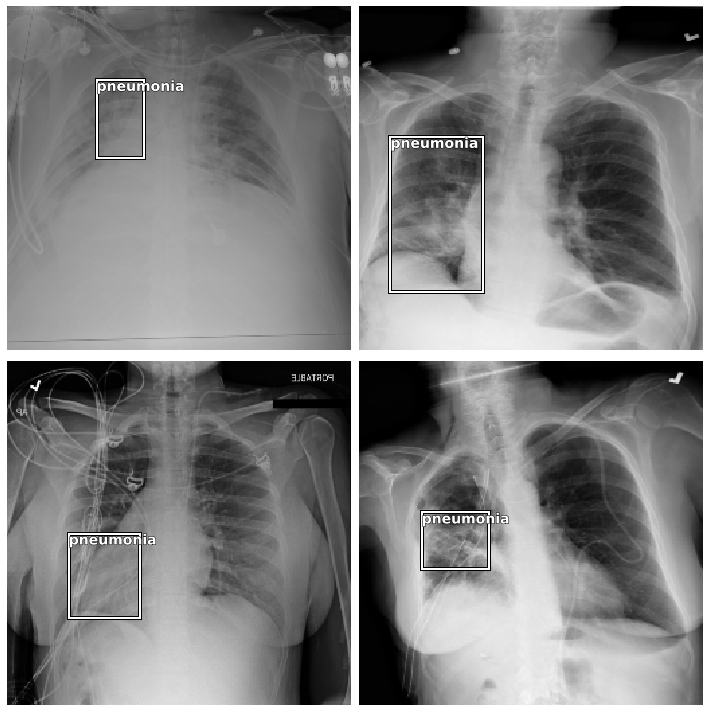

In [19]:
data.show_batch(rows=2, figsize=(10, 10))

In [12]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [14]:
anchors.shape

torch.Size([24480, 4])

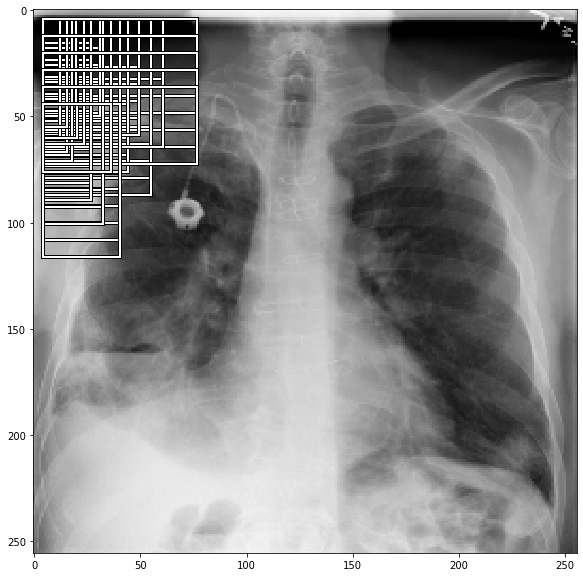

In [18]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:100]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [12]:
n_classes = data.c

loss = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet50, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)

epoch,train_loss,valid_loss,time
0,3.128320,#na#,01:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 3.63E-04


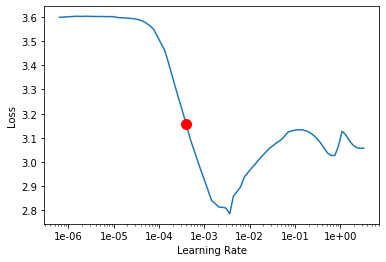

In [13]:
learn = Learner(data, model, loss_func=loss)

learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [14]:
learn.fit_one_cycle(5, 3.63e-04)

epoch,train_loss,valid_loss,time
0,1.737483,1.097973,01:14
1,1.087198,0.929127,01:08
2,0.891402,0.881723,01:09
3,0.797652,0.840186,01:09
4,0.740421,0.827380,01:08


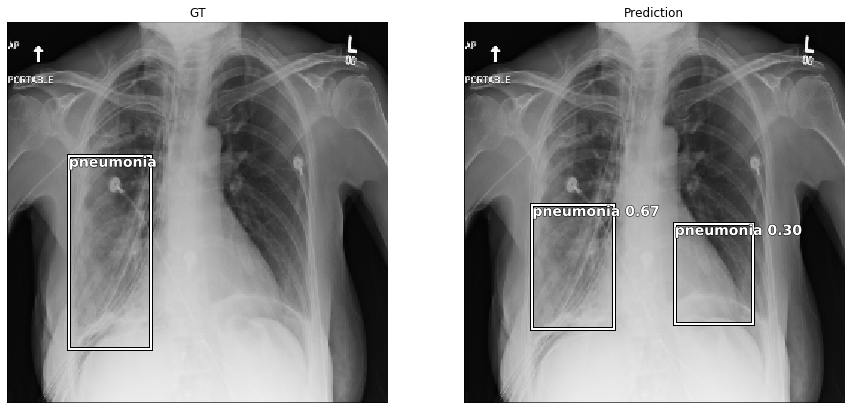

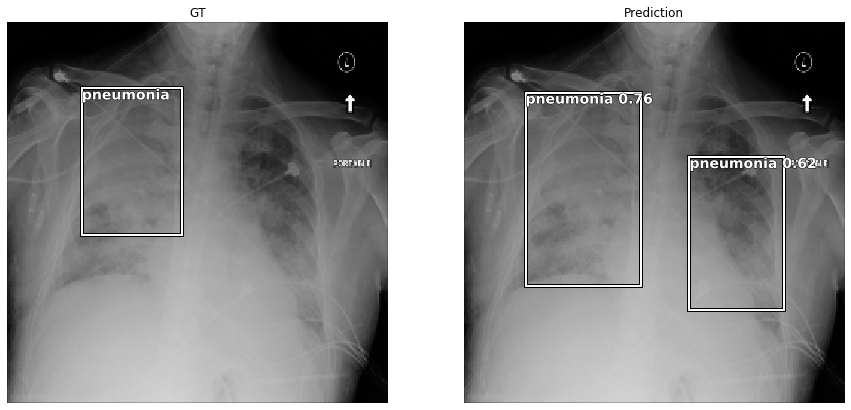

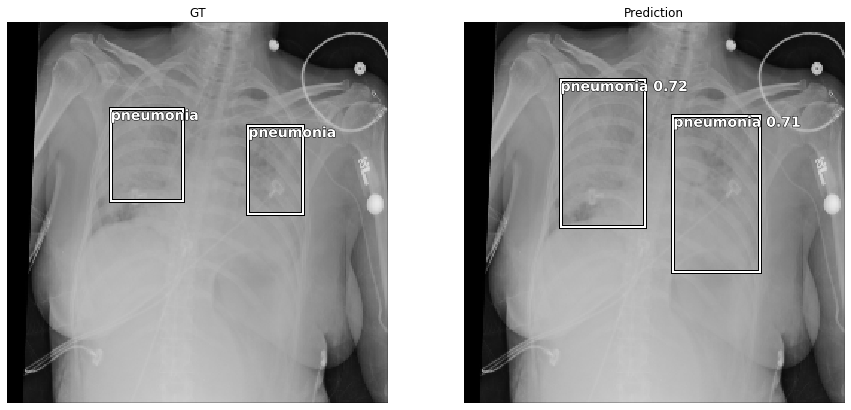

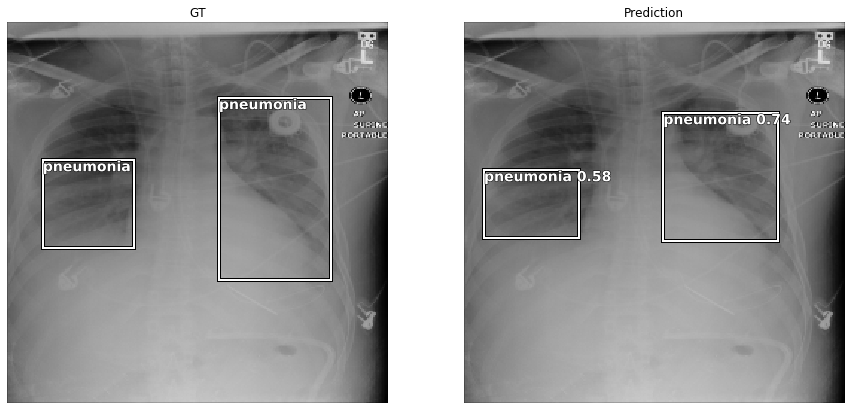

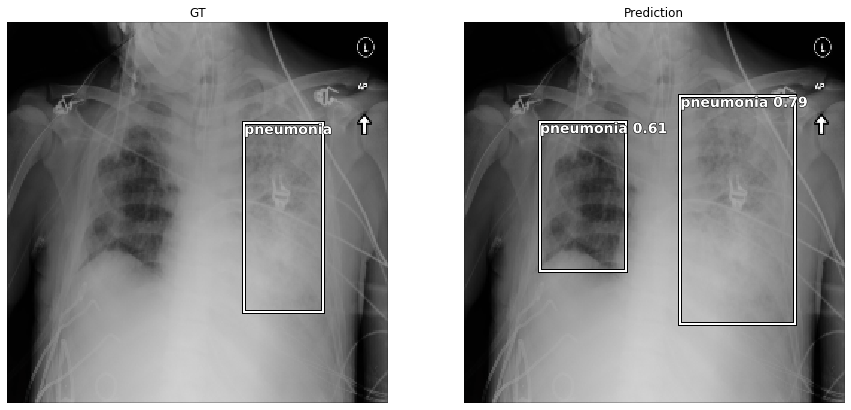

In [15]:
show_results_side_by_side(learn, anchors, detect_thresh=0.25, nms_thresh=0.1, image_count=5)

In [16]:
voc_map = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn.validate(metrics=[voc_map])

GT: 100%|██████████| 1889/1889 [00:00<00:00, 4583.68it/s]


[0.82738006, 0.5020923954258568]

epoch,train_loss,valid_loss,time
0,2.094232,#na#,00:59


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.75E-07


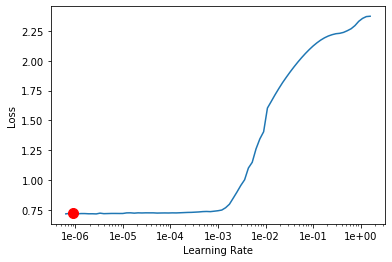

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
learn.fit_one_cycle(5, slice(1e-6, 5e-04))

epoch,train_loss,valid_loss,time
0,0.726931,0.835066,01:11
1,0.743191,0.833248,01:11
2,0.721135,0.833259,01:11
3,0.696977,0.815028,01:11
4,0.684186,0.812981,01:11


In [19]:
learn.validate(metrics=[voc_map])

GT: 100%|██████████| 1889/1889 [00:00<00:00, 4575.91it/s]


[0.81298053, 0.503754114995359]

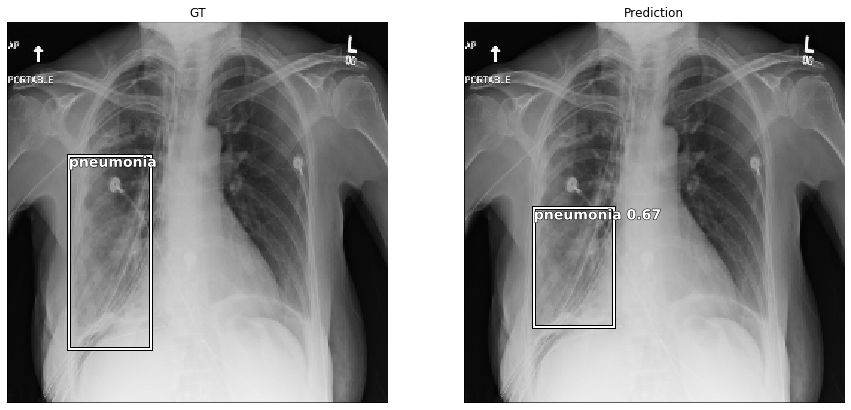

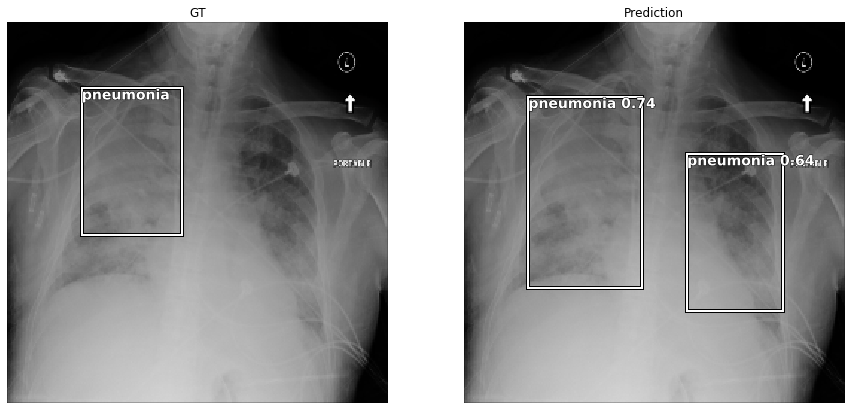

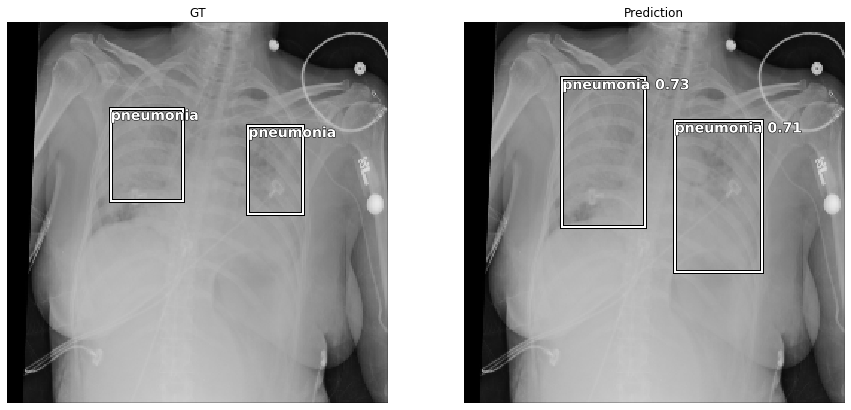

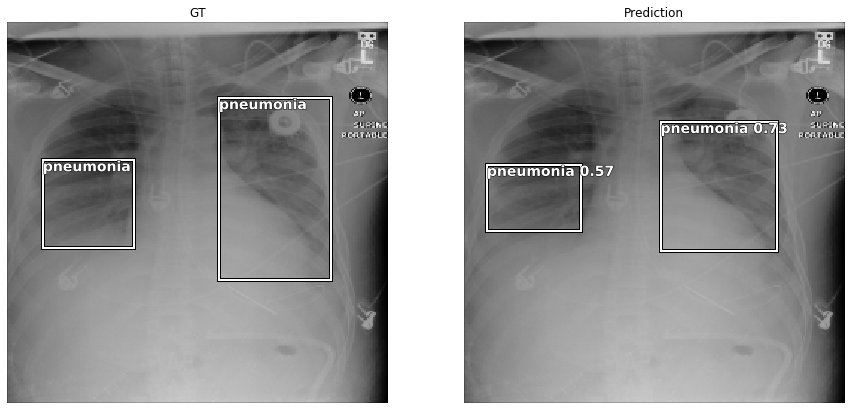

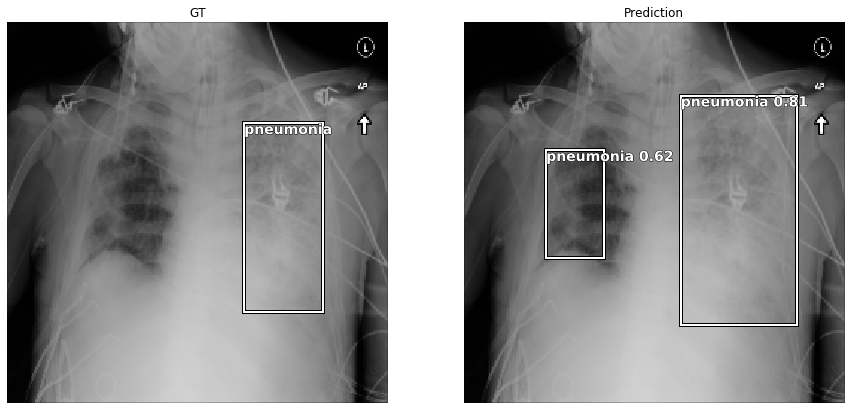

In [20]:
show_results_side_by_side(learn, anchors, detect_thresh=0.25, nms_thresh=0.1, image_count=5)